Required imports and notebook settings

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# See: https://stackoverflow.com/a/43028034 for "%matplotlib inline"
# See: https://stackoverflow.com/a/54329088 for "%config InlineBackend.figure_format = 'retina'"

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

Download and prepare the data to use with the neural network

In [2]:
from torchvision import datasets, transforms

# EMNIST data needs to be oriented correctly
# It has to rotate 90 degrees anti-clockwise then flip horizontally
transform = transforms.Compose(
    [
        lambda img: transforms.functional.rotate(img, -90),
        lambda img: transforms.functional.hflip(img),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

training_set = datasets.EMNIST(
    "./", split="letters", download=True, train=True, transform=transform
)
testing_set = datasets.EMNIST(
    "./", split="letters", download=True, train=False, transform=transform
)
training_data = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
testing_data = torch.utils.data.DataLoader(testing_set, batch_size=64, shuffle=True)

A show case of what the data looks like

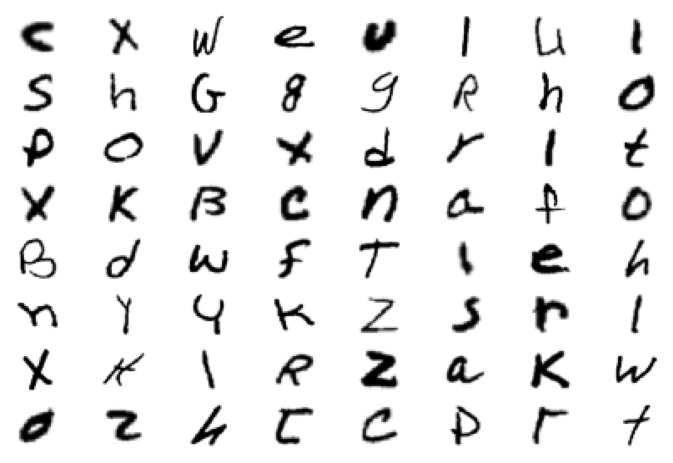

In [3]:
# Warning: Re-running this will give completely different sets of data
images, labels = iter(training_data).next()

figure = plt.figure()
total_images = 64
for idx in range(0, total_images):
    plt.subplot(8, 8, idx + 1)  # Subplots are 1-indexed
    plt.axis("off")
    plt.imshow(
        images[idx].numpy().squeeze(), cmap="gray_r"
    )  # .squeeze() removes dimensions of input size 1 in a tensor

Setup and create the neural network model

In [4]:
from torch import nn

input_layer = 784  # Total pixels of each 28x28 image
first_hidden_layer = 128  # Reduce raw pixel data to 128 nodes
second_hidden_layer = 64  # Reduce previous hidden layer to 64 nodes
output_layer = 27  # Final output of 26 letters (needs to be 27 due to index)

# Build a feed-forward network
model = nn.Sequential(
    nn.Linear(input_layer, first_hidden_layer),
    nn.ReLU(),
    nn.Linear(first_hidden_layer, second_hidden_layer),
    nn.ReLU(),
    nn.Linear(second_hidden_layer, output_layer),
    nn.LogSoftmax(dim=1),
)

has_cuda = torch.cuda.is_available()
if has_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.to(device)
print(f"Using '{device}' to run the neural network.")

Using 'cuda' to run the neural network.


Train the model

In [5]:
from torch import optim

from datetime import datetime

has_cuda = torch.cuda.is_available()
# lr is shorthand for learning rate
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
criterion = nn.NLLLoss()

start = datetime.now()
epochs = 20
for e in range(epochs):
    running_loss = 0
    for images, labels in training_data:
        # Flatten images into 1-dimensional vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        if has_cuda:
            output = model(images.cuda())
            loss = criterion(output, labels.cuda())
        else:
            output = model(images.cpu())
            loss = criterion(output, labels.cpu())

        # Backpropagate
        loss.backward()

        # Optimize weights
        optimizer.step()

        running_loss += loss.item()
    training_loss = running_loss / len(training_data)
    print(f"Epoch {e + 1} - Training loss: {training_loss}")

elpased_seconds = (datetime.now() - start).total_seconds()
print(f"\nTotal training time: {elpased_seconds / 60:.2f} minutes")

Epoch 1 - Training loss: 1.3452333394533549
Epoch 2 - Training loss: 0.684401695850568
Epoch 3 - Training loss: 0.5195398400838559
Epoch 4 - Training loss: 0.4396082797952187
Epoch 5 - Training loss: 0.3905229000479747
Epoch 6 - Training loss: 0.3591373869853142
Epoch 7 - Training loss: 0.33590180073411036
Epoch 8 - Training loss: 0.3158886638512978
Epoch 9 - Training loss: 0.30257576875961745
Epoch 10 - Training loss: 0.2898022716320478
Epoch 11 - Training loss: 0.27800346043629526
Epoch 12 - Training loss: 0.2678297152370214
Epoch 13 - Training loss: 0.2598653079741276
Epoch 14 - Training loss: 0.25285328925038
Epoch 15 - Training loss: 0.24445455353229473
Epoch 16 - Training loss: 0.23788679209466163
Epoch 17 - Training loss: 0.2316278977271838
Epoch 18 - Training loss: 0.22653349573604573
Epoch 19 - Training loss: 0.22052015730394767
Epoch 20 - Training loss: 0.21660737925232984

Total training time: 14.00595 minutes


Helper utility functions

In [6]:
def to_letter(class_index: int) -> str:
    """Helper function to convert classification index into a letter"""
    import string

    if class_index == 0:
        return "*"
    return string.ascii_lowercase[class_index - 1]


def to_letters(class_indices: list) -> list:
    return [f"{to_letter(index).upper()}/{to_letter(index)}" for index in class_indices]


def view_prediction(class_size: int, image_data, probabilities):
    """Helper function to display the model's predicted letter and its probabilities"""
    probabilities = probabilities.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(4, 2.75), ncols=2)

    # Show the image data
    ax1.imshow(image_data.resize_(1, 28, 28).numpy().squeeze(), cmap="gray_r")
    ax1.axis("off")

    # Show the probability chart
    ax2.barh(np.arange(class_size), probabilities)
    ax2.set_aspect(0.1)

    ax2.invert_yaxis()
    ax2.set_yticks(np.arange(class_size))
    ax2.set_yticklabels(to_letters(np.arange(class_size)))
    ax2.tick_params(axis="both", which="major", labelsize=5)

    ax2.set_xlim(0, 1)

    ax2.set_title("Letter Probability", fontsize=7)

    plt.tight_layout()

Show case the model's prediction for a single image

Predicted: I/i
Actual: Q/q


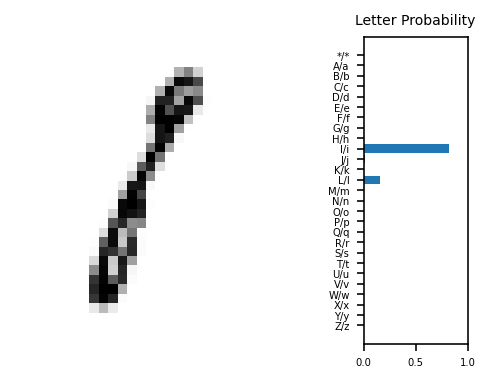

In [8]:
# You can re-run this to see different predictions made by the model
has_cuda = torch.cuda.is_available()
class_size = 27  # Total classifications

images, labels = next(iter(testing_data))

img = images[0].view(1, 784)
with torch.no_grad():
    # these are log probabilities
    if has_cuda:
        log_probabilities = model(img.cuda())
    else:
        log_probabilities = model(img.cpu())

probabilities = torch.exp(log_probabilities)  # raise log probailities exponentially
guesses = list(probabilities.cpu().numpy()[0])
guess = guesses.index(max(guesses))
actual = labels[0]

view_prediction(class_size, img.view(1, 28, 28), probabilities)
print(f"Predicted: {to_letter(guess).upper()}/{to_letter(guess)}")
print(f"Actual: {to_letter(actual).upper()}/{to_letter(actual)}")

Evaluate the model

In [10]:
total = correct = 0

for images, labels in testing_data:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            # these are log probabilities
            if has_cuda:
                log_probabilities = model(img.cuda())
            else:
                log_probabilities = model(img.cpu())

        probabilities = torch.exp(
            log_probabilities
        )  # raise log probailities exponentially
        probabilities = list(probabilities.cpu().numpy()[0])
        guess = probabilities.index(max(probabilities))
        actual = labels.numpy()[i]
        if guess == actual:
            correct += 1
        total += 1

print(f"Total images tested: {total}")
print(f"The model has an accuracy of {(correct/total) * 100:.2f}%")

Total images tested: 20800
The model has an accuracy of 90.11%
